## PIMS Hackathon, Seattle 2025
### Project B - Preconditioners for Thermal Radiative Transfer
Packages: jupyter, numpy, matplotlib

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from library import *

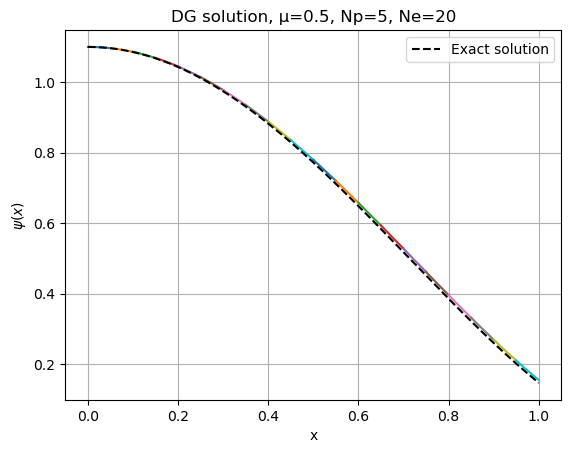

In [5]:
# ─── Example usage ───

# Parameters for the transport problem
μ       = 0.5
σ_t     = lambda x: x**2 + 1
source  = lambda x: (μ**3)*(2*x - 6.8*np.sin(2*x)) + (σ_t(x) * (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)))
inflow  = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x))

# Mesh parameters
xs      = np.linspace(0, 1, 21) # Mesh points / element boundaries
Np      = 5                     # Legendre polynomials per element (basis size)

# Plot numerical solution against the exact solution (MMS)
ψ_MMS     = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x))
ψ_weights = transport_direct_solve(μ, σ_t, source, inflow, Np, xs)
plot_solution(ψ_weights, xs, Np, μ=μ, exact_ψ_func=ψ_MMS)